## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [7]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)        
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Estimate Pulse Rate Algorithm

    Estimate Pulse Rate on PGG and acceleration data. 
    Compare with ECG ground truth and caculate MAE and confident

    Returns:
        Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
        np.array(errors): Array contain error for each window 8s
        np.array(confidence): Array contain condidence for each window 8s
        
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Compute pulse rate estimates and estimation confidence.
    # Load BPM
    ref_bpm = sp.io.loadmat(ref_fl)['BPM0']
    
    # total time in seconds
    total_time = 5*60
    fs = 125 #len(ppg)/total_time
    
    # if diferent less than threshold_bpm we consider ppg_pulse_rate = acc_dominant_rate
    threshold_bpm = 5
    
    # Use the 40-240BPM range to create your pass band.
    lowcut_fs = 40 / 60
    highcut_fs = 240 / 60
    ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
    acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
    acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
    
    # caculate number of windows
    window_size = round(8 * fs)
    step_size = round(2 * fs)
    n_windows = round((len(ppg_bpf) - window_size) // step_size + 1)
    if n_windows > len(ref_bpm): 
        n_windows = len(ref_bpm)
        
    errors, confidence = [], []
    # Loop through all windows
    for i in range(n_windows):
        # Get start end of the windows
        start = i * step_size
        end = start + window_size
        # Extract windowed signal
        ppg_window = ppg_bpf[start:end]
        acc_mag_window = acc_mag_bpf[start:end]
        
        #acc_mag_window = np.sqrt(accx_window**2 + accy_window**2 + accz_window**2)
        #acc_mag_window = BandpassFilter(acc_mag_window, (lowcut_fs, highcut_fs), fs)
        
        # Frequency domain analysis
        freqs = np.fft.rfftfreq(len(ppg_window), 1/fs)
        ppg_fft = np.abs(np.fft.rfft(ppg_window))
        acc_mag_fft = np.abs(np.fft.rfft(acc_mag_window))
        
        # PGG Dominant frequencies
        ppg_dominant_freq_idx = np.argmax(ppg_fft)
        ppg_dominant_freq = freqs[ppg_dominant_freq_idx]
        ppg_pulse_rate = ppg_dominant_freq * 60
        
        # Acceleration Dominant frequencies
        acc_dominant_freq_idx = np.argmax(acc_mag_fft)
        acc_dominant_freq = freqs[acc_dominant_freq_idx]
        acc_dominant_rate = acc_dominant_freq * 60
        
        #debug_pgg = np.argsort(ppg_fft)[::-1]
        #print("debug:",i ,ppg_pulse_rate, "shorted", freqs[debug_pgg[1:8]]*60,"acc_dominant_freq",acc_dominant_rate, 'ECG', ref_bpm[i][0])
        
        # Check for interference
        # When the dominant or harmonic accelerometer frequency is the same as the PPG, 
        # try picking the next strongest PPG frequency if there is another good candidate.
        if (np.abs(ppg_pulse_rate - acc_dominant_rate) < threshold_bpm) \
                or (np.abs(ppg_pulse_rate - acc_dominant_rate/2) < threshold_bpm) \
                or (np.abs(ppg_pulse_rate - acc_dominant_rate*2) < threshold_bpm):  # If interference is detected
            sorted_ppg_indices = np.argsort(ppg_fft)[::-1]  # Sort frequencies by power
            # loop through first 4 frequencies
            for idx in sorted_ppg_indices[:4]: 
                candidate_freq = freqs[idx]
                candidate_bpm = candidate_freq * 60
                # Check if any candidate is not the dominant or harmonic accelerometer frequency
                if (np.abs(acc_dominant_rate - candidate_bpm) >= threshold_bpm) \
                        and (np.abs(acc_dominant_rate*2 - candidate_bpm) >= threshold_bpm)\
                        and (np.abs(acc_dominant_rate/2 - candidate_bpm) >= threshold_bpm):
                    ppg_pulse_rate = candidate_bpm
                    break
        
        # Max magnitude frequency
        est_fs = ppg_pulse_rate / 55
        fs_win = 30/60
        fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs +fs_win)
        
        conf = np.sum(ppg_fft[fs_win_e])/np.sum(ppg_fft)         
        err = np.abs(ppg_pulse_rate - ref_bpm[i][0])
        
        errors.append(err)
        confidence.append(conf)
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return np.array(errors), np.array(confidence)

def BandpassFilter(signal, pass_band, fs):
    """Bandpass Filter.
    
    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band. Frequency components outside 
            the two elements in the tuple will be removed.
        fs: (number) The sampling rate of <signal>
        
    Returns:
        (np.array) The filtered signal
    """
    b, a = sp.signal.butter(3, pass_band, btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)
Evaluate()

9.7811791134032724

In [11]:
LoadTroikaDataFile(data_fls[0]).shape

(4, 37937)

In [9]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

In [10]:
for f in range(len(data_fls)):
    ref = sp.io.loadmat(ref_fls[f])['BPM0']
    data = sp.io.loadmat(data_fls[f])['sig']
    print(data.shape, len(ref), data_fls[f])

(6, 37937) 148 ./datasets/troika/training_data/DATA_01_TYPE01.mat
(6, 37850) 148 ./datasets/troika/training_data/DATA_02_TYPE02.mat
(6, 35989) 140 ./datasets/troika/training_data/DATA_03_TYPE02.mat
(6, 27576) 107 ./datasets/troika/training_data/DATA_04_TYPE01.mat
(6, 37250) 146 ./datasets/troika/training_data/DATA_04_TYPE02.mat
(6, 37328) 146 ./datasets/troika/training_data/DATA_05_TYPE02.mat
(6, 38373) 150 ./datasets/troika/training_data/DATA_06_TYPE02.mat
(6, 36650) 143 ./datasets/troika/training_data/DATA_07_TYPE02.mat
(6, 40803) 160 ./datasets/troika/training_data/DATA_08_TYPE02.mat
(6, 38042) 149 ./datasets/troika/training_data/DATA_10_TYPE02.mat
(6, 36500) 143 ./datasets/troika/training_data/DATA_11_TYPE02.mat
(6, 37316) 146 ./datasets/troika/training_data/DATA_12_TYPE02.mat


In [8]:
from matplotlib import pyplot as plt

In [9]:
# total time in seconds
total_time = 5*60
fs = 125
#Use the 40-240BPM range to create your pass band.
lowcut_fs = 40 / 60
highcut_fs = 240 / 60

In [10]:
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
accx_bpf = BandpassFilter(accx, (lowcut_fs,highcut_fs), fs)
accy_bpf = BandpassFilter(accy, (lowcut_fs,highcut_fs), fs)
accz_bpf = BandpassFilter(accz, (lowcut_fs,highcut_fs), fs)

Text(0,0.5,'Frequency (Hz)')

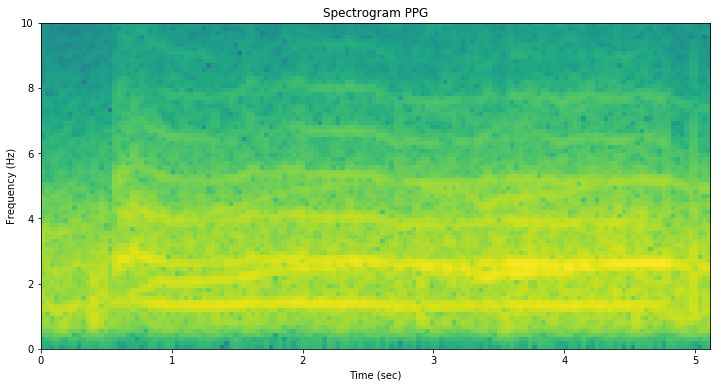

In [17]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram PPG')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 10)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

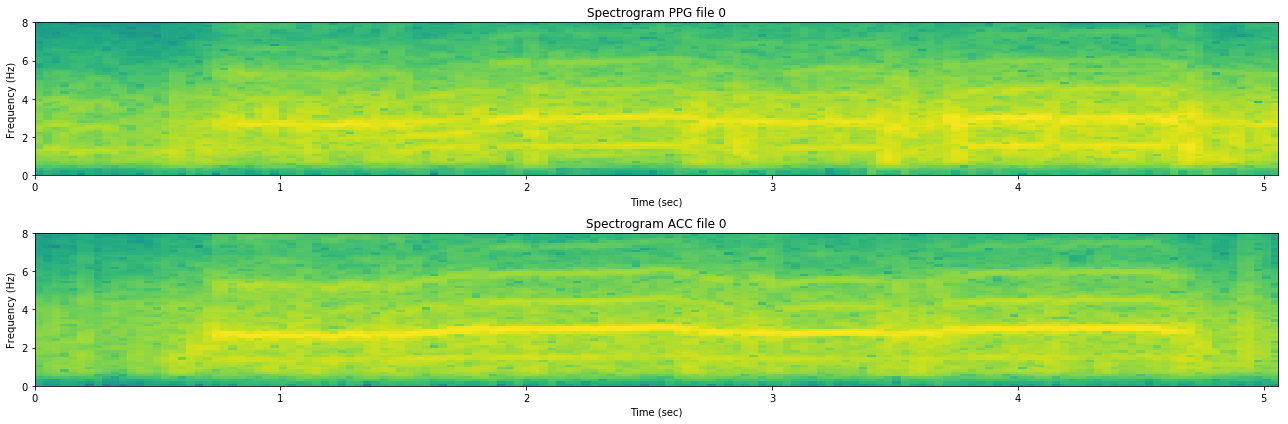

In [30]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
plt.title('Spectrogram PPG file 0')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
plt.title('Spectrogram ACC file 0')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

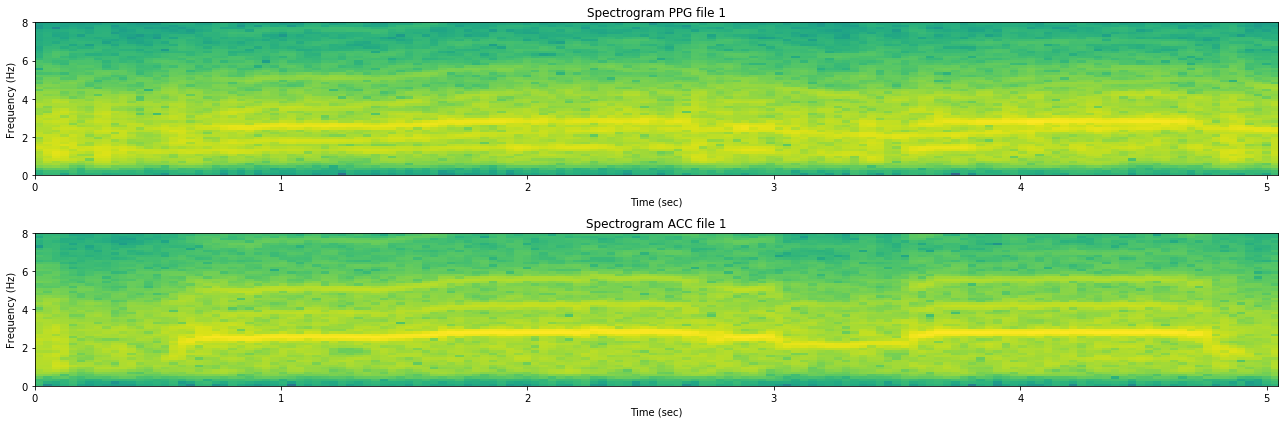

In [29]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[1])
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
plt.title('Spectrogram PPG file 1')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
plt.title('Spectrogram ACC file 1')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

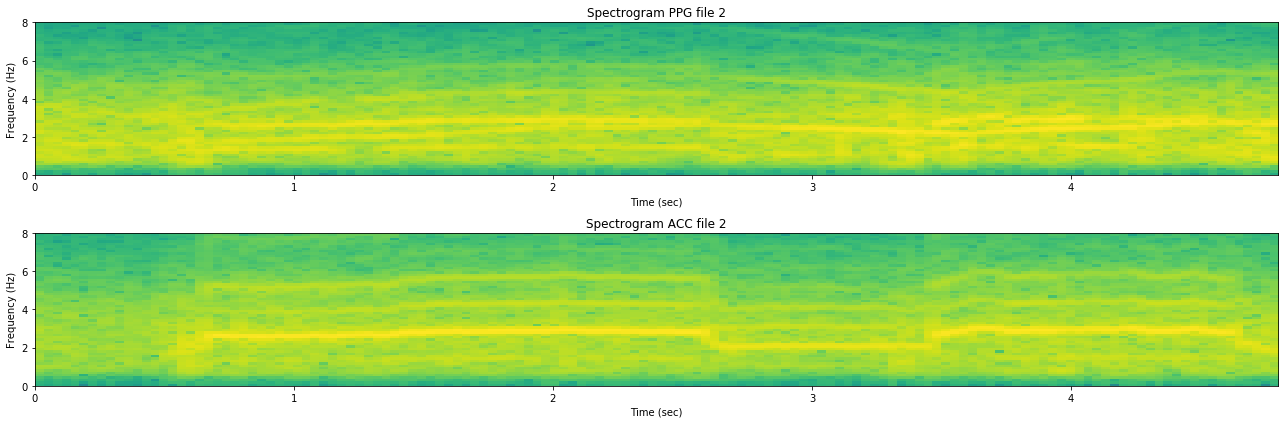

In [31]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[2])
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
plt.title('Spectrogram PPG file 2')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
plt.title('Spectrogram ACC file 2')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

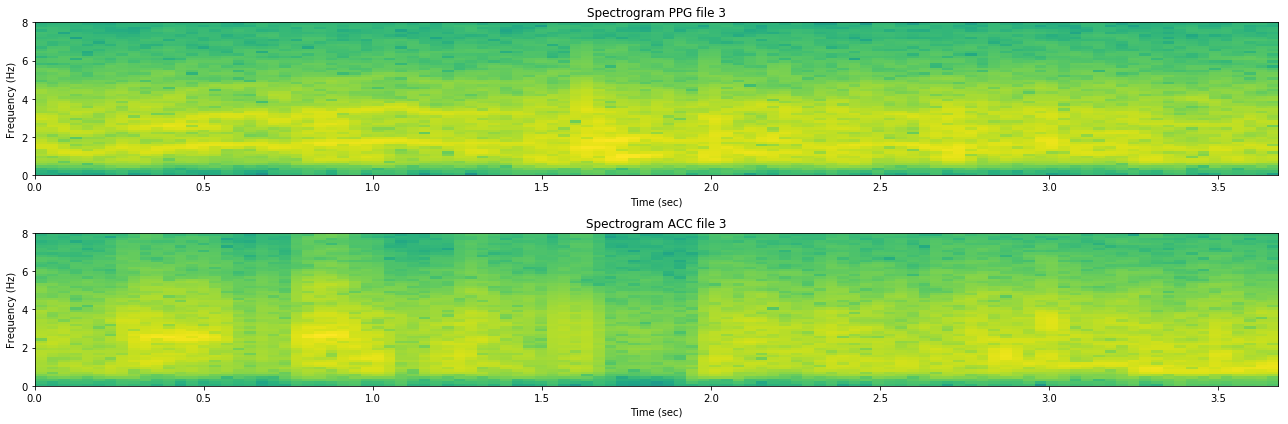

In [32]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[3])
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
plt.title('Spectrogram PPG file 3')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
plt.title('Spectrogram ACC file 3')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

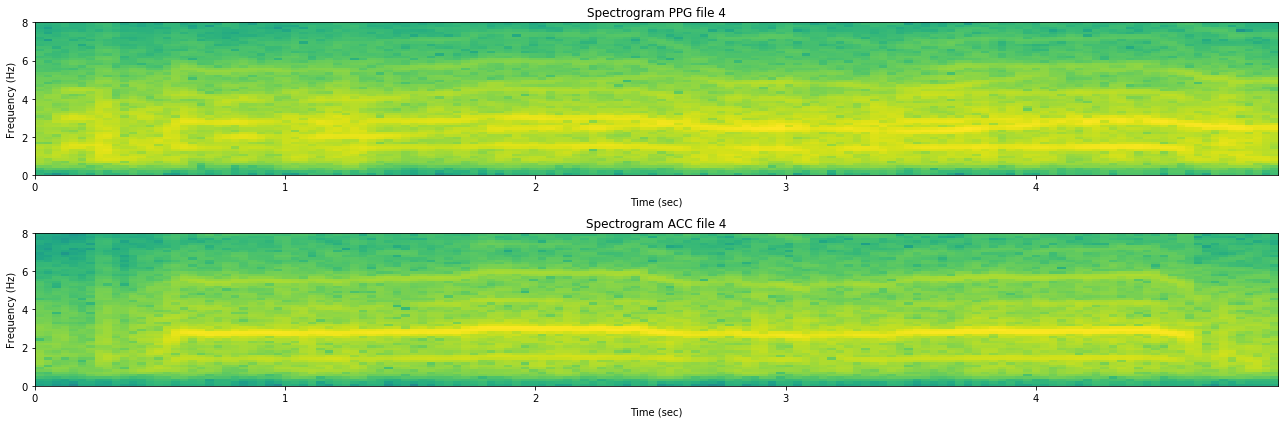

In [33]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[4])
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
plt.title('Spectrogram PPG file 4')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
plt.title('Spectrogram ACC file 4')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

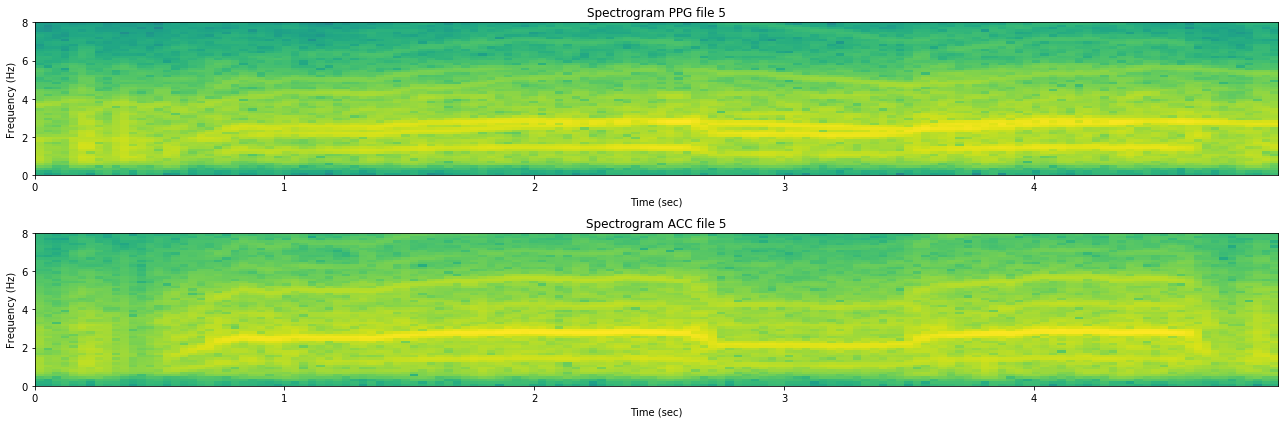

In [59]:
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[5])
ppg_bpf = BandpassFilter(ppg, (lowcut_fs,highcut_fs), fs)
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag, (lowcut_fs,highcut_fs), fs)
plt.figure(figsize=(18,6))
plt.subplot(2, 1, 1)
plt.title('Spectrogram PPG file 5')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.subplot(2, 1, 2)
plt.title('Spectrogram ACC file 5')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 8)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(ppg, label="Original Signal")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(ppg_bpf, label="Filtered Signal", color='orange')
plt.legend()
plt.xlabel("Time (seconds)")
plt.tight_layout()
plt.show()

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(accx[:14000], label="Original Signal")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(accx_bpf[:14000], label="Filtered Signal", color='orange')
plt.legend()
plt.xlabel("Time (seconds)")
plt.tight_layout()
plt.show()

Text(0,0.5,'Frequency (Hz)')

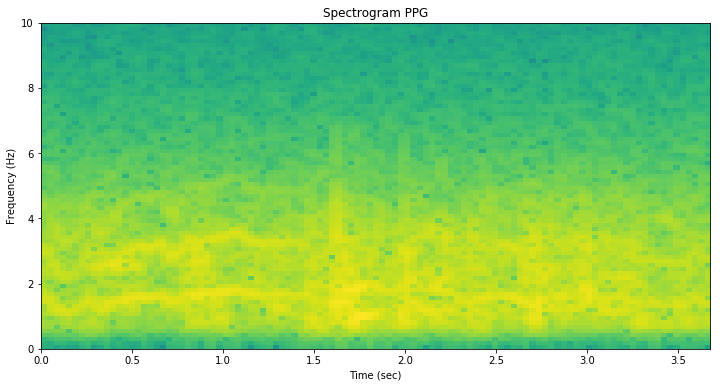

In [8]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram PPG')
plt.specgram(ppg_bpf, Fs=fs, NFFT=1000, noverlap=750, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 10)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram AAC-X')
plt.specgram(accx_bpf, Fs=fs, NFFT=250, noverlap=125, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 10)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram AAC-Y')
plt.specgram(accy_bpf, Fs=fs, NFFT=250, noverlap=125, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 10)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram AAC-Z')
plt.specgram(accz_bpf, Fs=fs, NFFT=250, noverlap=125, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 10)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

In [ ]:
acc_mag = np.sqrt(accx**2 + accy**2 + accz**2)
acc_mag_bpf = BandpassFilter(acc_mag,(lowcut_fs,highcut_fs),fs)
freqs = np.fft.rfftfreq(len(ppg_bpf), 1/fs)
ppg_fft = np.abs(np.fft.rfft(ppg_bpf))
acc_fft = np.abs(np.fft.rfft(acc_mag_bpf))

In [ ]:
ppg_bpf

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(ppg_bpf[5000:6000], label="PPG")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(acc_mag_bpf[5000:6000], label="ACC MAG", color='orange')
plt.legend()
plt.xlabel("Time (seconds)")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Spectrogram AAC-MAG')
plt.specgram(acc_mag_bpf, Fs=fs, NFFT=250, noverlap=125, xextent=((0, len(ppg_bpf)/fs/60)))
plt.ylim(0, 10)
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')

In [ ]:
#In each of this kind of datasets, there is a variable 'BPM0',
#which gives the BPM value in every 8-second time window. Note that two successive time windows
#overlap by 6 seconds. Thus the first value in 'BPM0' gives the calcualted heart rate ground-truth in
#the first 8 seconds, while the second value in 'BPM0' gives the calculated heart rate ground-truth
#from the 3rd second to the 10th second. 
ref_data = sp.io.loadmat(ref_fls[0])['BPM0']
len(ref_data)

In [ ]:
dominant_freq_idx = np.argmax(ppg_fft)
dominant_freq = freqs[dominant_freq_idx]
ppg_pulse_rate = dominant_freq * 60

In [ ]:
sorted_ppg_indices = np.argsort(ppg_fft)[::-1]
sorted_ppg_indices

In [ ]:
window_size = 8 * fs
step_size = 2 * fs
n_windows = (len(ppg_bpf) - window_size) // step_size + 1
n_windows

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works: 
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...
> - **Code Description**
>   - In **Code** section, update data_dir = "./datasets/troika/training_data" to your data folder
>   - Run code section it will return the mean absolute error at 90% availability
> - **Data Description**
>   - Refer to https://dcjorbkaum.prod.udacity-student-workspaces.com/files/datasets/troika/training_data/Readme.pdf
>   - All signals were sampled at 125 Hz
>   - It has 6 rows. The first row is a simultaneous recording of ECG, which is recorded from the chest of each subject. The second row and the third row are two channels of PPG, which are recorded from the wrist of each subject. The last three rows are simultaneous recordings of acceleration data (in x-, y-, and z-axis).
>   - DATA_04_TYPE01 is shorter than other
>   - The are 10 TYPE01 files but only 2 TYPE02 file. The data is not balance. Better to have more TYPE02 data.
> - **Algorithhm Description**
>   - Accelerometer magnitude is the square root of the sum of the squared value of movement in each of the 3 axes.
>   - Use the 40-240BPM range to create pass band filter.
>   - Get PGG Dominant frequencies Accelerometer magnitude Dominant frequencies
>   - When the dominant or harmonic accelerometer frequency is the same as the PPG Dominant frequencies, try picking the next strongest PPG frequency if there is another good candidate.
>   - The heart beating is not the only phenomenon that modulates the PPG signal. Blood in the wrist is fluid, and arm movement will cause the blood to move correspondingly. During exercise, like walking or running, we see another periodic signal in the PPG due to this arm motion.
>   - Algorithm output 3 values estimate pulse rate (BMP), Condience (%) and Error MEA (BPM)
>   - Algorithm use window side 8s, overlap 6s. 
>   - Algorithm check the pulse rate and Accelerometer rate are the same in window 5 BMP
>   - Algorithm compare pulse dominant rate with acc_dominant_rate, acc_dominant_rate * 2 and acc_dominant_rate / 2
>   - Algorithm work with "ran on a treadmill" data only. Other activity data may cause the failured.
>   - Poor sensor contact, low signal amplitude, or weak perfusion can degrade the PPG signal quality.
>   - Algorithm assume that pulse rate is in range 40-240BMP. If anybody has pulse rate outside this range, the algorithm will failed
> - **Algorithm Performance**
>   - Error is absolute different between estimated pulse rate and truth ground data
>   - Error will be high if the pulse rate is not in the first 4 strongest PPG frequency
>   - Confidence is summing the frequency spectrum near the pulse rate estimate and dividing it by the sum of the entire spectrum.
>   - Confidence is low with the windows has pulse rate is not the strongest one. When the dominant or harmonic accelerometer frequency is the same as the PPG Dominant frequencies, we try picking the next strongest PPG frequency if there is another good candidate.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 